# The Forest Fire Model
## A rapid introduction to Mesa

The [Forest Fire Model](http://en.wikipedia.org/wiki/Forest-fire_model) is one of the simplest examples of a model that exhibits self-organized criticality.

Mesa is a new, Pythonic agent-based modeling framework. A big advantage of using Python is that it a great language for interactive data analysis. Unlike some other ABM frameworks, with Mesa you can write a model, run it, and analyze it all in the same environment. (You don't have to, of course. But you can).

In this notebook, we'll go over a rapid-fire (pun intended, sorry) introduction to building and analyzing a model with Mesa.

First, some imports. We'll go over what all the Mesa ones mean just below.

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

## Building the model

Most models consist of basically two things: agents, and an world for the agents to be in. The Forest Fire model has only one kind of agent: a tree. A tree can either be unburned, on fire, or already burned. The environment is a grid, where each cell can either be empty or contain a tree.

First, let's define our tree agent. The agent needs to be assigned **x** and **y** coordinates on the grid, and that's about it. We could assign agents a condition to be in, but for now let's have them all start as being 'Fine'. Since the agent doesn't move, and there is only at most one tree per cell, we can use a tuple of its coordinates as a unique identifier.

Next, we define the agent's **step** method. This gets called whenever the agent needs to act in the world and takes the *model* object to which it belongs as an input. The tree's behavior is simple: If it is currently on fire, it spreads the fire to any trees above, below, to the left and the right of it that are not themselves burned out or on fire; then it burns itself out. 

In [2]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Now we need to define the model object itself. The main thing the model needs is the grid, which the trees are placed on. But since the model is dynamic, it also needs to include time -- it needs a schedule, to manage the trees activation as they spread the fire from one to the other.

The model also needs a few parameters: how large the grid is and what the density of trees on it will be. Density will be the key parameter we'll explore below.

Finally, we'll give the model a data collector. This is a Mesa object which collects and stores data on the model as it runs for later analysis.

The constructor needs to do a few things. It instantiates all the model-level variables and objects; it randomly places trees on the grid, based on the density parameter; and it starts the fire by setting all the trees on one edge of the grid (x=0) as being On "Fire".

Next, the model needs a **step** method. Like at the agent level, this method defines what happens every step of the model. We want to activate all the trees, one at a time; then we run the data collector, to count how many trees are currently on fire, burned out, or still fine. If there are no trees left on fire, we stop the model by setting its **running** property to False.

In [3]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

## Running the model

Let's create a model with a 100 x 100 grid, and a tree density of 0.6. Remember, ForestFire takes the arguments *height*, *width*, *density*.

In [4]:
fire = ForestFire(100, 100, 0.6)

To run the model until it's done (that is, until it sets its **running** property to False) just use the **run_model()** method. This is implemented in the Model parent object, so we didn't need to implement it above.

In [5]:
fire.run_model()

That's all there is to it!

But... so what? This code doesn't include a visualization, after all. 

**TODO: Add a MatPlotLib visualization**

Remember the data collector? Now we can put the data it collected into a pandas DataFrame:

In [6]:
results = fire.dc.get_model_vars_dataframe()

And chart it, to see the dynamics.

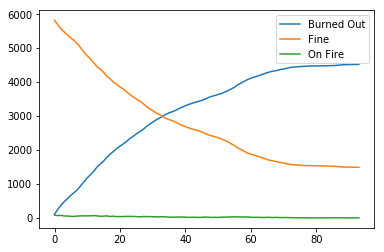

In [7]:
results.plot()

In this case, the fire burned itself out after about 90 steps, with many trees left unburned. 

You can try changing the density parameter and rerunning the code above, to see how different densities yield different dynamics. For example:

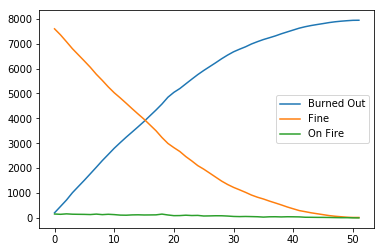

In [8]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

... But to really understand how the final outcome varies with density, we can't just tweak the parameter by hand over and over again. We need to do a batch run. 

## Batch runs

Batch runs, also called parameter sweeps, allow use to systemically vary the density parameter, run the model, and check the output. Mesa provides a BatchRunner object which takes a model class, a dictionary of parameters and the range of values they can take and runs the model at each combination of these values. We can also give it reporters, which collect some data on the model at the end of each run and store it, associated with the parameters that produced it.

For ease of typing and reading, we'll first create the parameters to vary and the reporter, and then assign them to a new BatchRunner.

In [15]:
param_set = {
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 'density':np.linspace(0,1,101)[1:]}

const_set = {
    'height': 50, # Height and width are constant
    'width':50,
}

In [16]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

In [17]:
# Create the batch runner
param_run = BatchRunner(ForestFire, param_set, const_set, model_reporters=model_reporter)

Now the BatchRunner, which we've named param_run, is ready to go. To run the model at every combination of parameters (in this case, every density value), just use the **run_all()** method.

In [18]:
param_run.run_all()

100it [00:04,  9.80it/s]


Like with the data collector, we can extract the data the batch runner collected into a dataframe:

In [19]:
df = param_run.get_model_vars_dataframe()

In [20]:
df.head()

,density,Run,BurnedOut,height,width
0,0.01,0,0.000000,50,50
1,0.02,1,0.000000,50,50
2,0.03,2,0.025974,50,50
3,0.04,3,0.037037,50,50
4,0.05,4,0.034783,50,50


As you can see, each row here is a run of the model, identified by its parameter values (and given a unique index by the Run column). To view how the BurnedOut fraction varies with density, we can easily just plot them:

(0, 1)

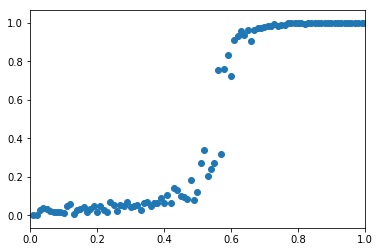

In [21]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

And we see the very clear emergence of a critical value around 0.5, where the model quickly shifts from almost no trees being burned, to almost all of them.

In this case we ran the model only once at each value. However, it's easy to have the BatchRunner execute multiple runs at each parameter combination, in order to generate more statistically reliable results. We do this using the *iteration* argument.

Let's run the model 5 times at each parameter point, and export and plot the results as above.

500it [00:04, 100.10it/s]


(0, 1)

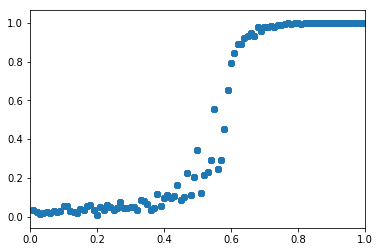

In [23]:
param_run = BatchRunner(ForestFire, param_set, const_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)